## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [Extract Digital Text from Handwritten content](https://aws.amazon.com/marketplace/pp/prodview-e6p34lolbimho)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

## Optical Character Recognition (HANDWRITTEN).


- **Model**: [en.handwritten.transformer.extraction](https://nlp.johnsnowlabs.com/2023/11/15/pdf_handwritten_transformer_extraction_en_3_2.html)
- **Model Description**:  This pipeline is designed to extract all handwritten text from (Multiple and Single) page PDFs or Image file.

In [1]:
model_package_arn = 'customer to specify model package arn reference number'

In [2]:
import base64
import shutil
import json
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
import boto3
from IPython.display import Image, display, IFrame
from PIL import Image as ImagePil
from urllib.parse import urlparse
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sage.Session()
s3_bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = get_execution_role()

sagemaker = boto3.client("sagemaker")
s3_client = sagemaker_session.boto_session.client("s3")
ecr = boto3.client("ecr")
sm_runtime = boto3.client("sagemaker-runtime")

## 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name = "en-handwritten-transformer-extraction-pipeline"

real_time_inference_instance_type = "ml.c5.9xlarge"
batch_transform_inference_instance_type = "ml.c5.9xlarge"

### A. Create an endpoint

In [5]:
# create a deployable model from the model package.
model = ModelPackage(
    role=role, model_package_arn=model_package_arn, sagemaker_session=sagemaker_session
)

# Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-----------!

Once endpoint has been created, you would be able to perform real-time inference.

In [6]:
import json
import pandas as pd
import os
import boto3

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def process_data_and_invoke_realtime_endpoint(pdf_file,content_type):
    with open(pdf_file, "rb") as file:
        pdf_data = file.read()

    i = 1
    input_extension = os.path.splitext(pdf_file)[-1]
    input_file_name = f'inputs/real-time/input{i}{input_extension}'

    while os.path.exists(input_file_name):
        i += 1
        input_file_name = f'inputs/real-time/input{i}{input_extension}'

    output_file_name = f'outputs/real-time/{os.path.basename(input_file_name)}.out'

    os.makedirs(os.path.dirname(input_file_name), exist_ok=True)
    os.makedirs(os.path.dirname(output_file_name), exist_ok=True)

    shutil.copy2(pdf_file, input_file_name)

    # Assuming s3_client is defined and used correctly
    validation_input_file_path = f"{model_name}/validation-input/real-time/{os.path.basename(input_file_name)}"
    s3_client.upload_file(pdf_file, s3_bucket, validation_input_file_path)

    # Assuming sm_runtime is defined and used correctly
    response = sm_runtime.invoke_endpoint(
        EndpointName=model_name,
        ContentType=content_type,
        Accept="application/json",
        Body=pdf_data,
    )

    # Process response
    response_data = json.loads(response["Body"].read().decode("utf-8"))

    # Save response data to file
    s3_client.put_object(Bucket=s3_bucket, Key=f"{model_name}/validation-output/real-time/{os.path.basename(output_file_name)}", Body=json.dumps(response_data).encode('UTF-8'))
    with open(output_file_name, 'w') as f_out:
        json.dump(response_data, f_out, indent=4)

    return response_data

### Download Images

In [7]:
!wget --no-check-certificate "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEn4BsqOK3uI8zFlqQ616FvpMz5HtQ3XBo5Q&s" -O input_handwritten_1.jpg
!wget --no-check-certificate "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ5vmzlKvaRuRYhlofOeyW4i3YOHyyizGQmog&s" -O ./input_handwritten_3.jpg
!wget --no-check-certificate "https://simplynoted.com/build/_assets/CanvasBaseImage-TRE36KJL.jpg" -O ./input_handwritten_4.jpg

--2024-07-25 10:50:38--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEn4BsqOK3uI8zFlqQ616FvpMz5HtQ3XBo5Q&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.253.115.100, 172.253.115.101, 172.253.115.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.253.115.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7588 (7.4K) [image/jpeg]
Saving to: ‘input_handwritten_1.jpg’

100%[======================================>] 7,588       --.-K/s   in 0s      

2024-07-25 10:50:38 (71.1 MB/s) - ‘input_handwritten_1.jpg’ saved [7588/7588]

--2024-07-25 10:50:38--  https://ocr-demo.abtosoftware.com/uploads/handwritten2.jpg
Resolving ocr-demo.abtosoftware.com (ocr-demo.abtosoftware.com)... 95.46.108.15
Connecting to ocr-demo.abtosoftware.com (ocr-demo.abtosoftware.com)|95.46.108.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186199 (182K) [image/jpeg]
Saving to: ‘./input_handwritt

#### Example 1 - Multiple Page PDF

In [8]:
image_paths = ['./input_handwritten_1.jpg', './input_handwritten_2.jpg']

images = [ImagePil.open(img_path).convert('RGB') for img_path in image_paths]

pdf_path = 'input_handwritten_1.pdf'
images[0].save(pdf_path, save_all=True, append_images=images[1:])

In [9]:
#IFrame("./input_handwritten_1.pdf", width=1000, height=800)

In [10]:
data =  process_data_and_invoke_realtime_endpoint(pdf_file='./input_handwritten_1.pdf', content_type='application/octet-stream')

In [11]:
df = pd.DataFrame(data["items"])

# Display the DataFrame
df

,text,pagenum
0,We Start With Good\nBecause all businesses should\nbe doing something good .,1
1,Last Wednesday\nWe had a good\nTeam building .,2


#### Example 2 -- Single PDF Example

In [12]:
image_paths = ['./input_handwritten_3.jpg']

images = [ImagePil.open(img_path).convert('RGB') for img_path in image_paths]

pdf_path = 'input_handwritten_2.pdf'
images[0].save(pdf_path, save_all=True)

In [13]:
#IFrame("./input_handwritten_2.pdf", width=1000, height=800)

In [14]:
data =  process_data_and_invoke_realtime_endpoint(pdf_file='./input_handwritten_2.pdf', content_type='application/octet-stream')

In [15]:
df = pd.DataFrame(data["items"])

# Display the DataFrame
df

,text,pagenum
0,I live in Lviv .\nEveryday I go\nto work by\nAlso I would\nlike to visit Mars .,1


#### Example 3 -- Image Example

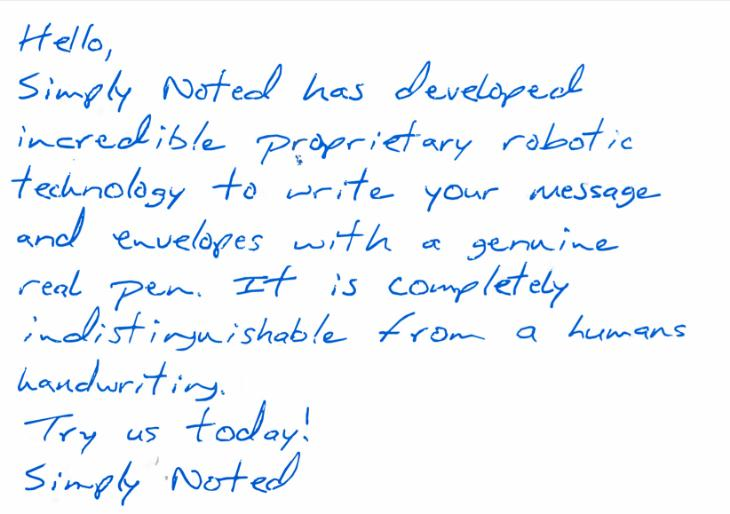

In [16]:
Image(filename='./input_handwritten_4.jpg')

In [17]:
data =  process_data_and_invoke_realtime_endpoint(pdf_file='./input_handwritten_4.jpg', content_type='application/octet-stream')

In [18]:
df = pd.DataFrame(data["items"])

# Display the DataFrame
df

,text
0,"hello ,\nSimply Noted has developed\nincredible proprietary robotic\ntechnology to write your message\nand envelopes with a genuine\nreal , Penn . It is completely\nindistinguishable from a humans\nhandwriting .\nTry us today !\nsimply "" Noted"


### C. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [19]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 3. Batch inference

In [20]:
validation_file_name1 = "input_handwritten_1.pdf"
validation_file_name2 = "input_handwritten_2.pdf"
validation_file_name3 = "input_handwritten_4.jpg"

validation_input_path = f"s3://{s3_bucket}/{model_name}/validation-input/batch"
validation_output_path = f"s3://{s3_bucket}/{model_name}/validation-output/batch"

input_dir = 'inputs/batch'
output_dir = 'outputs/batch'

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [22]:
def upload_pdf_to_s3(local_file_path):
    shutil.copy2(local_file_path, input_dir)
    base_file_name = os.path.basename(local_file_path)
    validation_input_file_path = f"{model_name}/validation-input/batch/{base_file_name}"
    s3_client.upload_file(local_file_path, s3_bucket, validation_input_file_path)

In [23]:
upload_pdf_to_s3(validation_file_name1)
upload_pdf_to_s3(validation_file_name2)
upload_pdf_to_s3(validation_file_name3)

In [24]:
# Initialize a SageMaker Transformer object for making predictions
transformer = model.transformer(
    instance_count=1,
    instance_type=batch_transform_inference_instance_type,
    accept="application/json",
    output_path=validation_output_path
)

transformer.transform(validation_input_path, content_type='application/octet-stream')
transformer.wait()

INFO:sagemaker:Creating transform job with name: en-handwritten-transformer-extraction-p-2024-07-25-10-52-27-376


.............................................INFO:     Will watch for changes in these directories: ['/app']
INFO:     Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)
INFO:     Started reloader process [7] using StatReload
24/07/25 10:59:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
#015[Stage 0:>                                                          (0 + 1) / 1]#015#015                                                                                #015INFO:     Started server process [9]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
📋 Loading license number 0 from /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👌 Launched #033cpu optimized#033 session with with: 🚀Spark-NLP==5.3.1, 🕶Spark-OC

In [25]:
def display_batch_output(file):
    parsed_url = urlparse(transformer.output_path)
    file_key = f"{parsed_url.path[1:]}/{file}.out"
    response = s3_client.get_object(Bucket=s3_bucket, Key=file_key)
    data = json.loads(response["Body"].read().decode("utf-8"))
    
    local_dir = os.path.join(output_dir,file + ".out")
    with open(local_dir, 'w') as f_out:
        json.dump(data, f_out, indent=4)

    df = pd.DataFrame(data["items"])
    display(df)

In [26]:
display_batch_output(validation_file_name1)

,text,pagenum
0,We Start With Good\nBecause all businesses should\nbe doing something good .,1
1,Last Wednesday\nWe had a good\nTeam building .,2


In [27]:
display_batch_output(validation_file_name2)

,text,pagenum
0,I live in Lviv .\nEveryday I go\nto work by\nAlso I would\nlike to visit Mars .,1


In [28]:
display_batch_output(validation_file_name3)

,text
0,"hello ,\nSimply Noted has developed\nincredible proprietary robotic\ntechnology to write your message\nand envelopes with a genuine\nreal , Penn . It is completely\nindistinguishable from a humans\nhandwriting .\nTry us today !\nsimply "" Noted"


In [29]:
model.delete_model()

INFO:sagemaker:Deleting model with name: en-handwritten-transformer-extraction-p-2024-07-25-10-52-26-651


### Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

